In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import Image
from IPython import display
import numpy as np
from scipy.spatial import Delaunay
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib widget


In [2]:
w1data = pd.read_csv("nfl-big-data-bowl-2023/week1.csv")
players_background = pd.read_csv("BigDataBowl2023/data2023/players.csv", index_col='nflId')
player_stats = pd.read_csv("BigDataBowl2023/merged_df.csv")
median_stats = pd.read_csv("BigDataBowl2023/all_pos_df.csv", index_col=0)
#player_stats.head()
#w1data.head()

In [3]:
def collect_game_info(weekdf, playId, saved=False):
    
    #slice df to single play
    playdf = weekdf.loc[weekdf["playId"] == playId]
    #reorder playdf so that they are in the right frame order
    playdf = playdf.sort_values(by = "frameId")
    if saved:
        playdf.to_csv(f'Play{playId}Frames.csv')
    return playdf

In [4]:
collect_game_info(w1data, 90,True)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
377637,2021091204,90,41251.0,1,2021-09-12T17:07:23.400,2.0,SF,left,73.56,15.30,1.04,0.97,0.11,74.46,34.20,None
377676,2021091204,90,41256.0,1,2021-09-12T17:07:23.400,1.0,SF,left,60.02,26.23,0.05,0.57,0.00,84.21,159.84,None
378222,2021091204,90,47791.0,1,2021-09-12T17:07:23.400,88.0,DET,left,76.60,18.80,1.84,1.94,0.19,283.77,343.82,None
377949,2021091204,90,44947.0,1,2021-09-12T17:07:23.400,30.0,DET,left,82.96,25.96,0.00,0.00,0.00,283.66,100.51,None
378339,2021091204,90,48455.0,1,2021-09-12T17:07:23.400,67.0,DET,left,76.40,29.12,0.00,0.00,0.00,258.99,88.78,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377870,2021091204,90,43290.0,39,2021-09-12T17:07:27.200,16.0,DET,left,85.00,33.71,5.86,1.46,0.59,339.16,8.39,None
377792,2021091204,90,42389.0,39,2021-09-12T17:07:27.200,3.0,SF,left,81.03,13.03,1.04,2.80,0.09,346.29,321.94,None
378377,2021091204,90,48455.0,39,2021-09-12T17:07:27.200,67.0,DET,left,76.72,23.42,1.97,1.31,0.20,230.09,333.73,None
378182,2021091204,90,46424.0,39,2021-09-12T17:07:27.200,45.0,DET,left,83.15,17.48,1.11,0.78,0.11,248.55,129.75,None


In [5]:
def delaunay(current_pos):
    stacked_pos = np.stack((np.vstack(current_pos[0]), np.vstack(current_pos[1])), axis=0)
    delaunay_triangulation1 = Delaunay(stacked_pos[0])
    delaunay_triangulation2 = Delaunay(stacked_pos[1])
    return delaunay_triangulation1, delaunay_triangulation2, stacked_pos

Simulated
Animating...


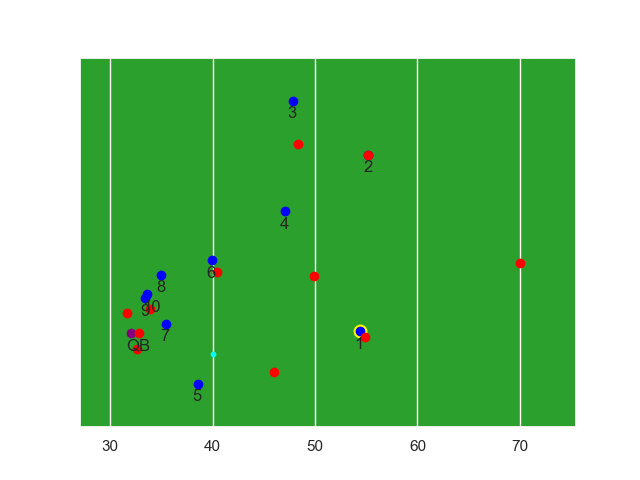

x                         43.62
y                         17.37
receiver rating    29078.080288
Name: 41233, dtype: object
x                         43.89
y                         39.14
receiver rating    26482.187567
Name: 35634, dtype: object
x                         43.03
y                         32.77
receiver rating    24812.488097
Name: 44896, dtype: object
x                         43.29
y                         31.71
receiver rating    23921.346314
Name: 35481, dtype: object
x                        37.79
y                        22.55
receiver rating    7415.097696
Name: 39985, dtype: object
x                        40.22
y                        22.51
receiver rating    7084.866491
Name: 46163, dtype: object
x                         40.5
y                        25.68
receiver rating    6251.848058
Name: 42404, dtype: object
x                        40.43
y                        24.66
receiver rating    6017.060291
Name: 40151, dtype: object
x                        39.

In [41]:
class Simulation:
    def __init__(self, weekdf, madden_df, median_df, players_background, playId):
        play = collect_game_info(weekdf, playId)

        # players.csv
        self.players_background = players_background
        # Make the madden nflId int and set as index
        madden_df.loc[:, 'nflId'] = madden_df['nflId'].astype('int64')
        madden_df = madden_df.set_index('nflId')
        self.madden_df = madden_df
        self.median_df = median_df

        self.play_df = play.dropna()
        self.ball_df = play[play['team'] == 'football']

        # convert frameId to integer values
        self.play_df.loc[:, 'frameId'] = self.play_df['frameId'].astype('int')
        # Do the same for nflIds
        self.play_df.loc[:, 'nflId'] = self.play_df['nflId'].astype('int64')

        # Reindex to players and frames (these are what we're plotting over)
        self.player_df = self.play_df.set_index(['nflId', 'frameId'])
        self.ball_df = self.ball_df.set_index(['frameId'])

        self.calc_mode = 'vor'
        # Stuff for plotting
        self.num_frames = len(self.play_df['frameId'].unique())
        self.num_players = len(self.play_df['jerseyNumber'].unique())
        self.teams = self.player_df['team'].unique()
        self.xrange = (self.player_df['x'].min()-5, self.player_df['x'].max()+5)
        self.yrange = (self.player_df['y'].min()-5, self.player_df['y'].max()+5)
        self.fig = plt.figure()
        self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)
        self.frames = None


    def model_frame(self, i):
        global qbx, qby
        """
        Calculates the score of the receivers on the attacking team for a single frame in the play dataframe
        TODO: ADD VORONOI/DELAUNAY
        :param i: frame number, starts at zero and ends at (self.num_frames - 1)
        :return: DataFrame of the
        """


        # Slice the player_df at frame i+1 (i is 1 behind the frameId)
        # Get the players dataframe for just this frame, removing the index of frame with .droplevel(-1)
        idx = pd.IndexSlice
        player_frame_df = self.player_df.loc[idx[:, i+1], :].droplevel(-1)
        ball_frame_df = self.ball_df.loc[i+1].to_frame().transpose() # the hatred towards pandas I have in this instant is unquantifiable with words
        ball_frame_df['nflId'] = 'football'
        ball_frame_df.set_index('nflId', inplace=True)

        # Find the nflId of the QB (theres probably a better way to do this but idk it)
        for nflId, player in player_frame_df.iterrows():
            pos = self.players_background.loc[nflId]['officialPosition']
            if pos =='QB':
                qb_Id = nflId
                qb_team = player['team']
                qbx, qby = player[['x', 'y']]


        # Sort the players into attackers and defenders
        attackers = player_frame_df[player_frame_df['team']==qb_team]
        defenders = player_frame_df[player_frame_df['team']!=qb_team]

        receiver_ratings = {'nflId':[], 'receiver rating':[]}

        qb_stats = self.madden_df.loc[qb_Id]

        throw_score = qb_stats['Throw On The Run'] + qb_stats['Throw Under Pressure'] + qb_stats['Throw Power'] # !!!
        if self.calc_mode == 'rr':#rr = reciever rating
            for nflId, player in attackers.iterrows():
                # We dont want to add the qb as a genuine receiver (maybe he could be? need to think about this though)
                if nflId != qb_Id:
                    player_position = self.players_background.loc[nflId]['officialPosition']

                    if nflId in self.madden_df.index:
                        player_stats = self.madden_df.loc[nflId]
                    else:
                        player_stats = self.median_df.loc[player_position]

                    x, y = player.loc[['x', 'y']]
                    # Calculate the distance between the qb and the player

                    # Calculate the scaling from the distance of the throw
                    dist = np.sqrt((qbx-x)**2+(qby-y)**2)
                    if dist >= 20:
                        throw_score += qb_stats['Throw Acc Deep']
                    elif dist >=10:
                        throw_score += qb_stats['Throw Acc Mid']
                    else:
                        throw_score += qb_stats['Throw Acc Short']
                    # Average the throw score over the 4 metrics used
                    throw_score /= 4 # !!!
                    catch_score = player_stats['Catching']

                    receiver_score = throw_score * catch_score * dist # !!!

                    # Add the player to the receiver_ratings dict
                    receiver_ratings['nflId'].append(nflId)
                    receiver_ratings['receiver rating'].append(receiver_score)
                else:
                    # Add qb as a nan
                    receiver_ratings['nflId'].append(qb_Id)
                    receiver_ratings['receiver rating'].append(np.nan)
        elif self.calc_mode == 'vor':
            resolution = 1
            player_best_scores = {}
            player_speeds = {}#this should probs be defined outside this loop oops
            for nflId, player in attackers.iterrows():#collecting speed scores + generating dicts of info
                player_best_scores[nflId] = 0
                player_position = self.players_background.loc[nflId]['officialPosition']
                if nflId in self.madden_df.index:
                                player_stats = self.madden_df.loc[nflId]
                else:
                                player_stats = self.median_df.loc[player_position]
                player_speeds[nflId] = player_stats['Speed'] + player_stats['Acceleration'] + player_stats['Agility']/3
            for nflId, player in defenders.iterrows():
                player_position = self.players_background.loc[nflId]['officialPosition']
                if nflId in self.madden_df.index:
                                player_stats = self.madden_df.loc[nflId]
                else:
                                player_stats = self.median_df.loc[player_position]
                player_speeds[nflId] = player_stats['Speed'] + player_stats['Acceleration'] + player_stats['Agility']/3

            for x in np.arange(self.xrange[0],self.xrange[1]+resolution,resolution):#loop over xcoords
                for y in np.arange(self.yrange[0],self.yrange[1]+resolution,resolution):#loop over ycoords
                    min_dist = 1000000 # big
                    score = 0 # how good the space is too pass to
                    for nflId, player in defenders.iterrows():
                        dist_2_point = np.sqrt((x-player['x'])**2+ (y-player['y'])**2) / player_speeds[nflId] # weighted distance using speeds
                        if dist_2_point < min_dist:
                            min_dist = dist_2_point#results in smallest dist from defending player
                    for nflId, player in attackers.iterrows():
                        
                        player_position = self.players_background.loc[nflId]['officialPosition']
                        dist_2_point = np.sqrt((x-player['x'])**2+ (y-player['y'])**2)/ player_speeds[nflId]
                        

                        if dist_2_point < min_dist: #only if attacking player is closer to point than defending player
                            min_dist = dist_2_point
                            throw_dist = np.sqrt((x-qbx)**2 + (y-qby)**2)
                            
                            if nflId in self.madden_df.index:
                                player_stats = self.madden_df.loc[nflId]
                            else:
                                player_stats = self.median_df.loc[player_position]

                            if throw_dist >= 20:
                                throw_score += qb_stats['Throw Acc Deep']
                            elif throw_dist >=10:
                                throw_score += qb_stats['Throw Acc Mid']
                            else:
                                throw_score += qb_stats['Throw Acc Short']
                            # Average the throw score over the 4 metrics used
                            throw_score /= 4 # !!!
                            catch_score = player_stats['Catching']
                            player_speed = player_speeds[nflId]
                            #score defined as: yard gain * 'chance of catching' (losely defined as throwscore X catchscore) * tanh(time ball takes to reach point/ time player takes to reach points)
                            #tanh thing a metric of will the player reach the catching zone before the ball if both going at max speed
                            score = (x-qbx)*  throw_score*catch_score*np.tanh((throw_dist*qb_stats['Throw Power'])/(min_dist*player_speed/3))#throw speed : player speed = roughly 3:1
                            if score > player_best_scores[nflId]:
                                player_best_scores[nflId] = score
            for Id in player_best_scores:
                pos = self.players_background.loc[Id]['officialPosition']
                if pos =='QB':
                     receiver_ratings['receiver rating'].append(-1000)
                else:
                    receiver_ratings['receiver rating'].append(player_best_scores[Id])
                
                receiver_ratings['nflId'].append(Id)
                
        # Turn the receiver_ratings dict to a df to merge with the attackers df
        rr_df = pd.DataFrame.from_dict(receiver_ratings)
        rr_df.set_index('nflId', inplace=True)

        # merge, and sort from best to worst receiver
        attackers = pd.merge(attackers, rr_df, how='left', left_index=True, right_index=True).sort_values('receiver rating', ascending=False)
        attackers['attacker'] = [True]*(len(attackers))
        defenders['receiver rating'] = [np.nan]*len(defenders)
        defenders['attacker'] = [False]*(len(defenders))
        frame = pd.concat([attackers, defenders, ball_frame_df])
        return frame
    
    

    def run_sim(self, calc_mode = 'vor'):
        """
        Iterates over the frame numbers, calculating the frames and storing them in self.frames.
        :return: None
        """
        self.calc_mode = calc_mode
        self.frames = [0] * self.num_frames
        for i in range(self.num_frames):
            self.frames[i] = self.model_frame(i)
        print("Simulated")
        return None

    def animate(self):
        print("Animating...")
        if self.frames is None:
            print("need to run_sim() before animating")
            return None

        sns.set_theme()
        plt.axis('off')
        #self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)

        def frame2plot(model_frame):
            """
            Converts a frame dataframe to useful plotting data
            :return:
            """
            attackers = model_frame[model_frame['attacker']==True][['x', 'y', 'receiver rating']]
            defenders = model_frame[model_frame['attacker']==False][['x','y']]
            football_coords = model_frame.loc['football'][['x','y']]
            return attackers, defenders, football_coords

        def init_func():
            for i in range(self.num_players):
                self.axes.plot([],[])

        def space_mode(resolution,attackers,defenders):
            x_field_arr = np.arange(self.xrange[0],self.xrange[1]+resolution,resolution)
            y_field_arr = np.arange(self.yrange[0],self.yrange[1]+resolution,resolution)
            z_arr = np.zeros([len(y_field_arr)-1,len(x_field_arr)-1])
            xi,yi = 0,0
            #this nested loop is omega poo
            for x in x_field_arr[:-1]:
                yi = 0
                for y in y_field_arr[:-1]:
                    min_dist = 1000000 # big
                    score = 0 # how good the space is too pass to
                    for nflId, player in defenders.iterrows():
                        dist_2_point = np.sqrt((x-player['x'])**2+ (y-player['y'])**2)
                        if dist_2_point < min_dist:
                            min_dist = dist_2_point#results in smallest dist from defending player
                    for nflId, player in attackers.iterrows():
                        dist_2_point = np.sqrt((x-player['x'])**2+ (y-player['y'])**2)
                        if dist_2_point < min_dist:
                            min_dist = dist_2_point
                            throw_dist = np.sqrt((x-qbx)**2 + (y-qby)**2)
                            score = (x-qbx)* np.tanh((throw_dist*27)/(min_dist*8.5))#27= variable for ball speed, 8.5 variable for player speed
                            best_player = player
                    z_arr[yi,xi] = score
                    yi += 1
                xi += 1
            return x_field_arr, y_field_arr, z_arr # returns array of scores for zones on the field, to plot as pcolormesh



        def animate_func(i):
            print(i, end="\r")
            self.axes.clear()
            plt.axis('off')
            self.axes = plt.axes(xlim=self.xrange, ylim=self.yrange)
            self.axes.set_facecolor("tab:green")          

            pitch_ticks = np.arange(0, 110, 10)
            mask = (self.xrange[0] <= pitch_ticks)  & (pitch_ticks <= self.xrange[1])
            ticks =pitch_ticks[mask]

            self.axes.set_xticks(ticks)
            self.axes.set_yticks([])

            self.axes.grid(True)
            attackers, defenders, football_coords = frame2plot(self.frames[i])
            mode = 'rank'
            if mode == 'rank':
                rank=1
                for nflId, player in attackers.iterrows():
                         
                    if player['receiver rating'] > -500:
                        if rank == 1:
                            self.axes.scatter(player['x'], player['y'], c='yellow', s=80, zorder=3)
                        self.axes.scatter(player['x'], player['y'], c='blue', zorder=5)      
                        self.axes.text(player['x']-0.5, player['y']-2, rank, zorder=10)                        
                        rank+=1
                    else:
                        self.axes.scatter(player['x'], player['y'], c='purple', zorder=5)  
                        self.axes.text(player['x']-0.5, player['y']-2, 'QB', zorder=10)        

                for nflId, player in defenders.iterrows():
                    self.axes.scatter(player['x']-0.5, player['y']-2, c='red', zorder=5)



            elif mode == 'space':#look across pitch to find best location to pass to
                resolution = 1
                x,y,z = space_mode(resolution,attackers,defenders)
                #self.axes.pcolormesh(x,y,z)
                #print(max(x), max(y))
                for nflId, player in attackers.iterrows():
                    self.axes.scatter(player['x'], player['y'], c='blue', zorder=5)
                
                for nflId, player in defenders.iterrows():
                    self.axes.scatter(player['x'], player['y'], c='red', zorder=5)
    

            self.axes.scatter(football_coords['x'], football_coords['y'], c='cyan', s=10, zorder=7)


        anim = animation.FuncAnimation(self.fig, func=animate_func, init_func=init_func, frames=self.num_frames, interval=1, blit=True)
        return anim


sim = Simulation(w1data, player_stats, median_stats, players_background, 97)
#s.model_frame(0)
sim.run_sim(calc_mode='vor')
anim = sim.animate()
writergif = animation.PillowWriter(fps=10)
anim.save('test.gif', writer=writergif)

In [31]:
path = 'test.gif'
file = open(path , "rb")
image = file.read()
progress= Image(
    value=image,
    format='gif',
    width=500,
    height=500)
display.display(progress)

Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00,\xa0+\xfe\xfe\xfeU\xb2U\xfe\x00\x00\x00\x00\xfe&\'\',\x9c+pj\…